In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
import os
import seaborn as sns
from sklearn import metrics, tree, ensemble
from sklearn.compose import ColumnTransformer

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import statsmodels.formula.api as smf
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/data_final5.csv"

In [ ]:
df = pd.read_csv(file_path)

In [ ]:
df['building_type'] = df['building_type'].astype('category')

In [ ]:
datatrain = df.iloc[:393588]
datatest = df.iloc[393588:491986]

In [ ]:
# Разделение данных на тренировочный и тестовый наборы
X_train = datatrain[['geo_lon', 'geo_lat', 'building_type', 'level', 'levels', 'rooms',
        'area', 'kitchen_area', 'object_type', 'distance_to_cemetery',
        'distance_to_attractions', 'distance_to_green_zone',
        'distance_to_metro_station', 'distance_to_polygon', 'KeyRate']]
y_train = datatrain['priceL']

X_test = datatest[['geo_lon', 'geo_lat', 'building_type', 'level', 'levels', 'rooms',
        'area', 'kitchen_area', 'object_type', 'distance_to_cemetery',
        'distance_to_attractions', 'distance_to_green_zone',
        'distance_to_metro_station', 'distance_to_polygon', 'KeyRate']]
y_test = datatest['priceL']

In [ ]:
num_features = list(X_train.columns)
num_features

['geo_lon',
 'geo_lat',
 'building_type',
 'level',
 'levels',
 'rooms',
 'area',
 'kitchen_area',
 'object_type',
 'distance_to_cemetery',
 'distance_to_attractions',
 'distance_to_green_zone',
 'distance_to_metro_station',
 'distance_to_polygon',
 'KeyRate']

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features)
    ])

X_train_norm = preprocessor.fit_transform(X_train)
X_test_norm = preprocessor.transform(X_test)
X_train.shape, X_test.shape

((393588, 15), (98398, 15))

In [ ]:
# Создание модели
model = keras.models.Sequential()
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(1, activation='relu'))

# Компиляция модели
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mape'])

In [ ]:
# создадим папку для моделей и лога
os.makedirs("models", exist_ok=True)

In [ ]:
# создаем чекпойнты для сохранения модели и редьюс он плато схедуллер
checkpoint = keras.callbacks.ModelCheckpoint("models/model.keras", verbose=0,
                                             save_best_only=True, monitor='val_mape',
                                             save_weights_only=False, mode='auto')
# если используем .h5, то используется интерфейс сохранения keras
# если бы мы хотели сохранять все модели, а потом провести детальный анализ, то следовало бы поставить save_best_only=False и задать путь в
# стиле 'models/model_{epoch:02d}_{val_acc:.2f}.h5'  - чтобы модели друг друга не перезаписывали

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                              patience=5, min_lr=0.01)

In [ ]:
# тренируем модель
history = model.fit(
    X_train_norm, y_train,
    batch_size=256,
    epochs=200,
    verbose=1,
    validation_data=(X_test_norm, y_test), callbacks=[checkpoint, reduce_lr])

Epoch 1/200
1538/1538 [==============================] - 9s 5ms/step - loss: 14.0679 - mape: 17.5634 - val_loss: 0.1919 - val_mape: 2.2152 - lr: 0.0010
Epoch 2/200
1538/1538 [==============================] - 5s 3ms/step - loss: 6.0905 - mape: 12.2872 - val_loss: 0.1661 - val_mape: 2.1396 - lr: 0.0010
Epoch 3/200
1538/1538 [==============================] - 8s 5ms/step - loss: 4.4533 - mape: 10.5753 - val_loss: 0.2275 - val_mape: 2.6309 - lr: 0.0010
Epoch 4/200
1538/1538 [==============================] - 5s 3ms/step - loss: 3.3968 - mape: 9.3108 - val_loss: 0.2403 - val_mape: 2.7335 - lr: 0.0010
Epoch 5/200
1538/1538 [==============================] - 6s 4ms/step - loss: 2.5842 - mape: 8.1103 - val_loss: 0.1547 - val_mape: 2.1074 - lr: 0.0010
Epoch 6/200
1538/1538 [==============================] - 7s 5ms/step - loss: 1.7915 - mape: 6.6537 - val_loss: 0.0905 - val_mape: 1.4817 - lr: 0.0010
Epoch 7/200
1538/1538 [==============================] - 5s 4ms/step - loss: 1.2179 - mape: 5.45

In [ ]:
frame_history_df = pd.DataFrame.from_dict(history.history)

In [ ]:
frame_history_df.tail(10)

,loss,mape,val_loss,val_mape,lr
190,0.040284,0.906905,0.038024,0.873378,0.001
191,0.040300,0.907043,0.034968,0.846374,0.001
192,0.040201,0.906467,0.035971,0.859059,0.001
193,0.040245,0.906793,0.032454,0.825450,0.001
194,0.040328,0.907279,0.038709,0.893812,0.001
195,0.040221,0.906198,0.034786,0.840813,0.001
196,0.040488,0.908289,0.034292,0.843033,0.001
197,0.040151,0.906676,0.034023,0.839413,0.001
198,0.040215,0.905785,0.034383,0.839009,0.001
199,0.040323,0.906381,0.034035,0.840981,0.001


In [ ]:
frame_history_df[frame_history_df["val_mape"] == frame_history_df["val_mape"].min()]

,loss,mape,val_loss,val_mape,lr
83,0.040992,0.914924,0.031928,0.799275,0.001


In [ ]:
frame_history_df.to_csv("models_log.csv", index=False)

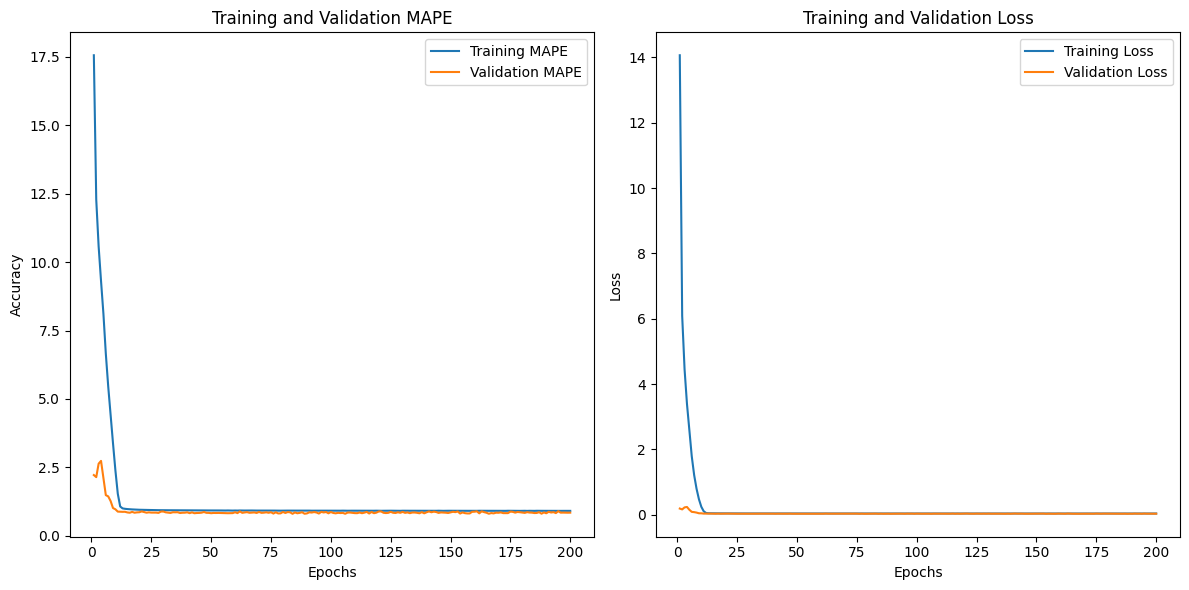

In [ ]:
# Задаем размер графиков
plt.figure(figsize=(12, 6))

# График точности (accuracy)
plt.subplot(1, 2, 1)
sns.lineplot(x=frame_history_df.index + 1, y=frame_history_df['mape'], label='Training MAPE')
sns.lineplot(x=frame_history_df.index + 1, y=frame_history_df['val_mape'], label='Validation MAPE')
plt.title('Training and Validation MAPE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# График потерь (loss)
plt.subplot(1, 2, 2)
sns.lineplot(x=frame_history_df.index + 1, y=frame_history_df['loss'], label='Training Loss')
sns.lineplot(x=frame_history_df.index + 1, y=frame_history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Вывод графиков
plt.tight_layout()
plt.show()

In [ ]:
# загрузим лучшую по точности модель:
model = keras.models.load_model("models/model.keras")

In [ ]:
y_test_r = datatest['price']

In [ ]:
print(model.predict(X_test_norm, verbose=0).reshape(-1,))

[15.535657 15.51116  15.755567 ... 15.465253 15.542397 16.391209]


In [ ]:
print(y_test_r)

393588     5100000.0
393589     5150000.0
393590     6500000.0
393591     7000000.0
393592    39000000.0
             ...    
491981     6900000.0
491982     5900000.0
491983     4535000.0
491984     6000000.0
491985    15990000.0
Name: price, Length: 98398, dtype: float64


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

print(mean_absolute_error(y_test_r, np.exp(model.predict(X_test_norm, verbose=1).reshape(-1,))))
print(mean_absolute_percentage_error(y_test_r, np.exp(model.predict(X_test_norm, verbose=1).reshape(-1,))))
print(np.sqrt(np.mean((model.predict(X_test_norm, verbose=1).reshape(-1,)) - (y_test))**2.0))

3075/3075 [==============================] - 4s 1ms/step
1491556.5074467978
3075/3075 [==============================] - 3s 892us/step
0.12644648371331926
3075/3075 [==============================] - 3s 886us/step
0.005118521980149413


3075/3075 [==============================] - 10s 3ms/step


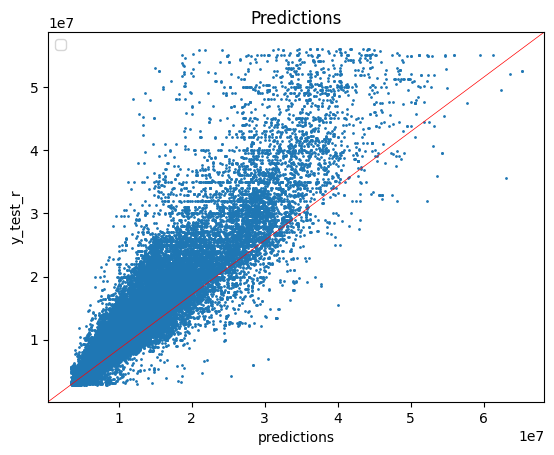

In [ ]:
import matplotlib.pyplot as plt

predictions = np.exp(model.predict(X_test_norm, verbose=1).reshape(-1,))

plt.scatter(predictions, y_test_r, s=1)
plt.xlabel('predictions')
plt.ylabel('y_test_r')
plt.title('Predictions')
plt.plot([0, 1], [0, 1], 'r-', linewidth=0.5, transform=plt.gca().transAxes)
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

rf_regressor = RandomForestRegressor(n_estimators=400, max_depth=15)
rf_regressor.fit(X_train, y_train)

# Make predictions on holdout set
y_pred_rf = rf_regressor.predict(X_test)

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xgb_regressor = XGBRegressor(objective='reg:squarederror', n_estimators = 1000, max_depth = 10, learning_rate = 0.1, enable_categorical = True)
xgb_regressor.fit(X_train, y_train)

# Make predictions on holdout set
y_pred_xgb = xgb_regressor.predict(X_test)

In [ ]:
#Ansamble stacking rf fcl
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

AS = 0.9*y_pred_rf + 0.1*model.predict(X_test_norm, verbose=0).reshape(-1,)

print(mean_absolute_error(y_test_r, np.exp(AS)))
print(mean_absolute_percentage_error(y_test_r, np.exp(AS)))
print((np.sqrt(np.mean(AS - (y_test))**2.0)))

1353041.0903654823
0.10874308060873793
0.06790564855328243


In [ ]:
#Ansamble stacking xgb fcl
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

AS1 = 0.9*y_pred_xgb + 0.1*model.predict(X_test_norm, verbose=0).reshape(-1,)

print(mean_absolute_error(y_test_r, np.exp(AS)))
print(mean_absolute_percentage_error(y_test_r, np.exp(AS)))
print((np.sqrt(np.mean(AS - (y_test))**2.0)))

1353041.0903654823
0.10874308060873793
0.06790564855328243


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_log_error

# Define the range of possible values for a1 and a2
a1_range = np.arange(0, 1, 0.1)
a2 = 1 - a1

# Initialize the minimum RMSLE and the corresponding values of a1 and a2
min_mae = float('inf')
best_a1 = None

# Iterate over all possible combinations of a1 and a2
for a1 in a1_range:
  AS = a1*y_pred_rf + a2*model.predict(X_test_norm, verbose=0).reshape(-1,)
  mae = (mean_absolute_error(y_test_r, np.exp(AS)))
  # Update the minimum RMSLE and the corresponding values of a1 and a2 if necessary
  if mae < min_mae:
    min_mae = mae
    best_a1 = a1

# Print the optimal values of a1 and a2
print("Optimal values: a1 =", best_a1)
print("Minimum MAE:", min_mae)

Optimal values: a1 = 0.9
Minimum MAE: 1346944.1856381034


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_log_error

# Define the range of possible values for a1 and a2
a1_range = np.arange(0, 1, 0.1)
a2 = 1 - a1

# Initialize the minimum RMSLE and the corresponding values of a1 and a2
min_mape = float('inf')
best_a1 = None

# Iterate over all possible combinations of a1 and a2
for a1 in a1_range:
  AS = a1*y_pred_xgb + a2*model.predict(X_test_norm, verbose=0).reshape(-1,)
  mape = (mean_absolute_percentage_error(y_test_r, np.exp(AS)))
  # Update the minimum RMSLE and the corresponding values of a1 and a2 if necessary
  if mape < min_mape:
    min_mape = mape
    best_a1 = a1

# Print the optimal values of a1 and a2
print("Optimal values: a1 =", best_a1)
print("Minimum MAE:", min_mape)

Optimal values: a1 = 0.9
Minimum MAE: 0.09039458488286148


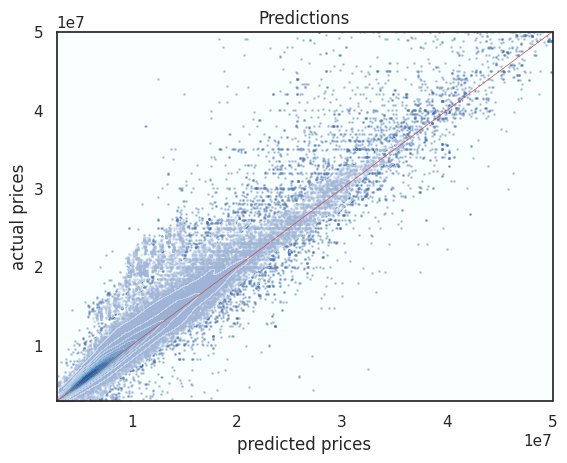

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# RF
plt.scatter(np.exp(AS), y_test_r, s=1, alpha=0.3)
plt.xlabel('predicted prices')
plt.ylabel('actual prices')
plt.title('Predictions')
plt.plot([0, 1], [0, 1], 'r-', linewidth=0.5, transform=plt.gca().transAxes)
plt.ylim(2850000, 50000000)
plt.xlim(2850000, 50000000)

sns.kdeplot(x=np.exp(AS), y=y_test_r, fill=True,
            cmap = "Blues", levels=10, alpha=0.5, bw_adjust=0.5)


plt.show()

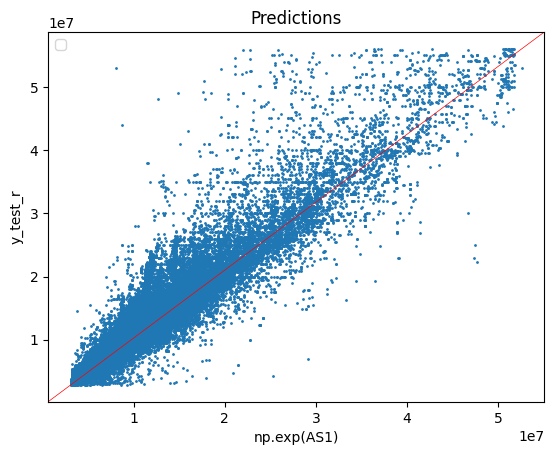

In [ ]:
#XGB
plt.scatter(np.exp(AS1), y_test_r, s=1)
plt.xlabel('np.exp(AS1)')
plt.ylabel('y_test_r')
plt.title('Predictions')
plt.plot([0, 1], [0, 1], 'r-', linewidth=0.5, transform=plt.gca().transAxes)
plt.legend()
plt.show()

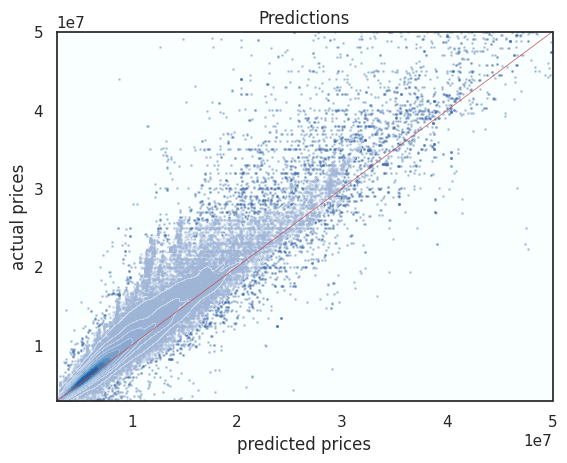

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# First plot
plt.scatter(np.exp(AS1), y_test_r, s=1, alpha=0.3)
plt.xlabel('predicted prices')
plt.ylabel('actual prices')
plt.title('Predictions')
plt.plot([0, 1], [0, 1], 'r-', linewidth=0.5, transform=plt.gca().transAxes)
plt.ylim(2850000, 50000000)
plt.xlim(2850000, 50000000)

sns.kdeplot(x=np.exp(AS1), y=y_test_r, fill=True,
            cmap = "Blues", levels=10, alpha=0.5, bw_adjust=0.5)


plt.show()

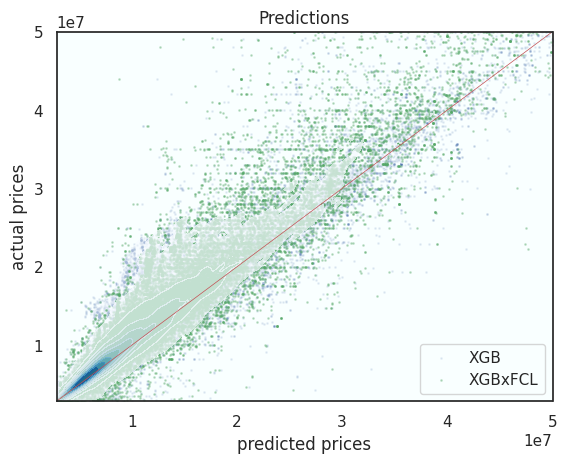

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot 1
plt.scatter(np.exp(y_pred_xgb), y_test_r, s=1, alpha=0.1, label='XGB')
plt.xlabel('predicted prices')
plt.ylabel('actual prices')
plt.title('Predictions')
plt.plot([0, 1], [0, 1], 'r-', linewidth=0.5, transform=plt.gca().transAxes)
plt.ylim(2850000, 50000000)
plt.xlim(2850000, 50000000)
sns.kdeplot(x=np.exp(y_pred_xgb), y=y_test_r, fill=True, cmap="Blues", levels=10, alpha=0.5, bw_adjust=0.5)

# Plot 2 (darker color)
plt.scatter(np.exp(AS1), y_test_r, s=1, alpha=0.3, label='XGBxFCL')
sns.kdeplot(x=np.exp(AS1), y=y_test_r, fill=True, cmap="Blues", levels=10, alpha=0.7, bw_adjust=0.5)

# Legend
plt.legend()

plt.show()

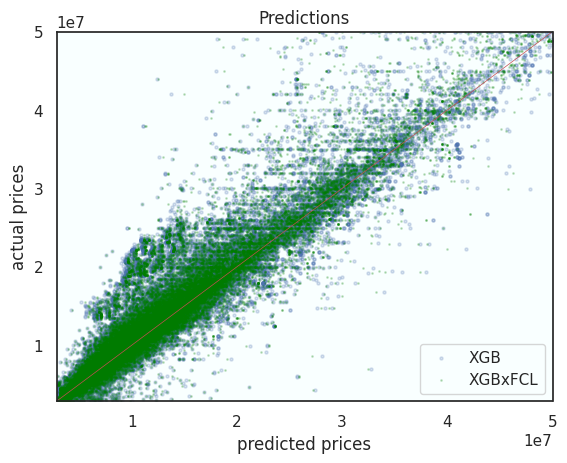

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot 1
plt.scatter(np.exp(y_pred_xgb), y_test_r, s=5, alpha=0.2, label='XGB')
plt.xlabel('predicted prices')
plt.ylabel('actual prices')
plt.title('Predictions')
plt.plot([0, 1], [0, 1], 'r-', linewidth=0.5, transform=plt.gca().transAxes)
plt.ylim(2850000, 50000000)
plt.xlim(2850000, 50000000)

# Plot 2 (darker color)
plt.scatter(np.exp(AS1), y_test_r, s=1, alpha=0.2, label='XGBxFCL', color = "green")

# Legend
plt.legend()

plt.show()